In [37]:
import numpy as np
import pandas as pd
import numpy.random as rd
import matplotlib
import matplotlib.pyplot  as plt
import math

rd.poisson(4, 100)

In [51]:
def prob(k, r):
    p = (np.exp(-r)) * (r**k) * (math.factorial(k)**(-1))
    return p

In [52]:
arr = np.empty((0,3), float)

In [53]:
# 真の強度をλ=4とする
for i in xrange(16):
    arr = np.append(arr, np.array([[prob(i, 3), prob(i, 4),  prob(i, 5)]]), axis=0)

In [54]:
df = pd.DataFrame(arr)

In [55]:
plt.style.use('ggplot') 

In [56]:
df

,0,1,2
0,4.978707e-02,0.018316,0.006738
1,1.493612e-01,0.073263,0.033690
2,2.240418e-01,0.146525,0.084224
3,2.240418e-01,0.195367,0.140374
4,1.680314e-01,0.195367,0.175467
5,1.008188e-01,0.156293,0.175467
6,5.040941e-02,0.104196,0.146223
7,2.160403e-02,0.059540,0.104445
8,8.101512e-03,0.029770,0.065278
9,2.700504e-03,0.013231,0.036266


In [57]:
df.columns = [u'λ=3', u'λ=4', u'λ=5']

In [58]:
fig = df.plot()

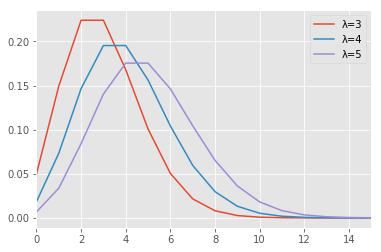

In [59]:
plt.show()

In [62]:
# カルバック・ライブラー情報量を計算
def cal_DKL(colA, colB):
    s = df.apply(lambda x: x[colA] * np.log(x[colA]) - x[colA] * np.log(x[colB]) , axis=1)
    return s.sum()

In [69]:
cal_DKL(colA=u'λ=3', colB=u'λ=4')

0.13695423713851146

In [70]:
cal_DKL(colA=u'λ=5', colB=u'λ=4')

0.11553432956890478

In [71]:
# 真のλ(=4)とのカルバック・ライブラー情報量で比較すると、λ=3よりもλ=5のほうがより小さい値をとる

# 最尤推定してみる

In [74]:
# 要素x, 2値分類cのセットをN個つくる。
# cの分離線をf(x)=x-1とする。
from scipy import optimize

In [90]:
def make_data(N, draw_plot=True, is_confused=False, confuse_bin=50):
    rd.seed(1) # シードを固定して、乱数が毎回同じ出力になるようにする
    feature = rd.randn(N)
    d = pd.DataFrame(feature, columns=['x'])
    # 2値分類の付与：人為的な分離線の上下どちらに居るかで機械的に判定
    d['c'] = d.apply(lambda A : 1 if (A['x']-1)>0 else 0,  axis=1)
    # 撹乱:データを少し複雑にするための操作
    if is_confused:
        def get_model_confused(data):
            c = 1 if (data.name % confuse_bin) == 0 else data.c 
            return c
        
        d['c'] = d.apply(get_model_confused, axis=1)

    if draw_plot:
        d.plot()

    return d

In [91]:
da = make_data(1000)
da.head(5)

,x,c
0,1.624345,1
1,-0.611756,0
2,-0.528172,0
3,-1.072969,0
4,0.865408,0


In [101]:
da.plot(x='x', y='c', kind='scatter')

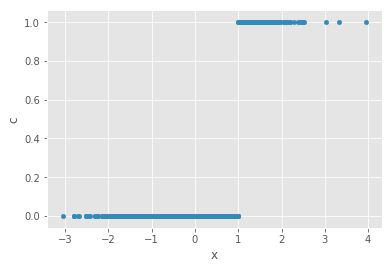

In [102]:
plt.show()

In [112]:
da2 = make_data(1000, is_confused=True, confuse_bin=50)
da2.plot(x='x', y='c', kind='scatter')

In [151]:
def sigmoid(z):
    return 0.0 if z < -500 else 1.0 / (1 + np.exp(-z))

In [152]:
def get_prob(x, weight_vector):
    feature_vector =  np.array([x, 1])
    z = np.inner(feature_vector, weight_vector)
    return sigmoid(z)

In [153]:
# 対数尤度の和を定義する
def define_likelihood(weight_vector, *args):
    likelihood = 0
    df_data = args[0]

    for x, c in zip(df_data.x, df_data.c):
        prob = get_prob(x, weight_vector)
        i_likelihood = np.log(prob) if c==1 else np.log(1.0-prob)
        likelihood = likelihood - i_likelihood

    return likelihood

In [154]:
def estimate_weight(df_data, initial_param):
    param = optimize.minimize(define_likelihood, initial_param, args=(df_data), method='Nelder-Mead')
    
    return param.x

In [155]:
weight_vector = rd.rand(2)

In [156]:
weight_vector

array([ 0.74413592,  0.59052055])

In [157]:
weight_vector = estimate_weight(da, weight_vector)

In [158]:
weight_vector

array([ 6129.28251603, -6087.65017584])

In [159]:
# 回帰曲線を散布図にのせてみる


In [161]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(-4, 4, 0.1)
ax.plot(x, sigmoid(x))
ax.set_xlabel('$z_{i}$')
ax.set_ylabel('$q$')
fig.savefig('logistic.png')
plt.close(fig)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()